In [1]:
import delfi
print(delfi.__version__)

0.8.0


## Simulator

In [2]:
from delfi.simulator import TwoMoons

m = TwoMoons(mean_radius=0.1, sd_radius=0.01, baseoffset=0.25)

In [3]:
thetas = m.gen_posterior_samples(n_samples=1000)

In [4]:
import matplotlib.pyplot as plt
plt.scatter(thetas[:,0], thetas[:,1])
plt.xlim(-1, 1);
plt.ylim(-1, 1);

## Prior

In [5]:
import delfi.distribution as dd
import numpy as np

p = dd.Uniform(lower=[-1, -1], upper=[1, 1])

In [6]:
p.gen(1)

array([[-0.36175058,  0.87873291]])

## Summary statistics

We will not reduce the dimensionality of our data, and instead just apply the identity:

In [7]:
from delfi.summarystats import Identity

s = Identity()

## Generator

Having defined the simulator, prior, and summary statistics, we instantiate a generator object:

In [8]:
from delfi.generator import Default

g = Default(model=m, prior=p, summary=s)

Having specified the generator, we can draw parameters and data using the gen() method:

In [9]:
params, stats = g.gen(5000)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Theta')

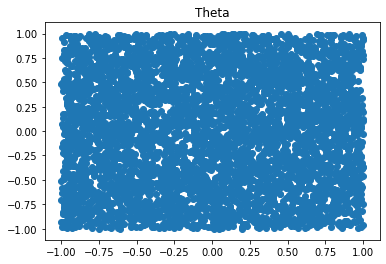

In [11]:
plt.scatter(params[:,0], params[:,1])
plt.title('Theta')

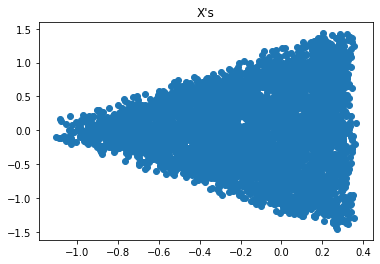

In [12]:
plt.title('X\'s')
plt.scatter(stats[:,0], stats[:,1])

# Inference

In [13]:
x0 = np.array([[0., 0.]])

## Basic density estimation based LFI

In [14]:
%%capture
from delfi.inference import Basic

inf_basic = Basic(obs = x0, generator=g, n_components=2, n_hiddens=[10])

In [15]:
log, train_data, _ = inf_basic.run(n_train=4000)

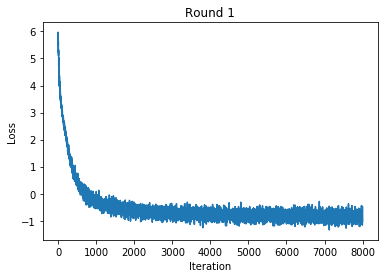

In [16]:
plt.figure()
for i in range(len(log)):
    plt.subplot(1, len(log), i + 1)
    plt.plot(log[i]['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Round {0}'.format(i + 1))

Say we observed $x_o = 0.$ and want to predict the posterior $\hat{p}(\theta | x=x_{\text{o}})$:

In [17]:
posterior = inf_basic.predict(x0)

In [18]:
posterior

In [19]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))

component 1: mixture weight = 0.00; mean = -0.38; variance = 1.67
component 2: mixture weight = 1.00; mean = -0.00; variance = 0.04


In [20]:
posterior.eval([1., 1.])

array([-11.93518945])

Text(0.5, 0, 'y_1')

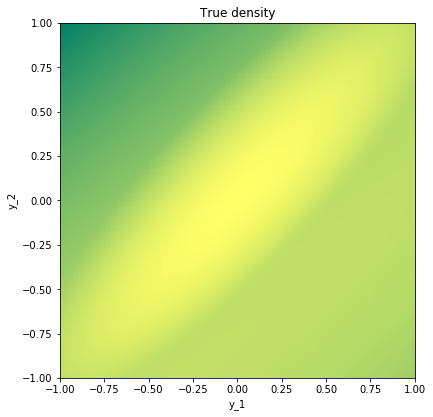

In [21]:
X_LIMS = (-1, 1)
Y_LIMS = (-1, 1)
Nb_point_per_dimension = 300

X_LIMS = (X_LIMS[0], X_LIMS[1])
Y_LIMS = (Y_LIMS[1], Y_LIMS[0])

x1 = np.linspace(*X_LIMS, Nb_point_per_dimension)
x2 = np.linspace(*Y_LIMS, Nb_point_per_dimension)
x1, x2 = np.meshgrid(x1, x2)
x1 = x1.ravel()
x2 = x2.ravel()

z = np.c_[x1, x2] # z should be renamed to y

estimated_density = posterior.eval(z).reshape(Nb_point_per_dimension,Nb_point_per_dimension)
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(estimated_density, extent=([X_LIMS[0], X_LIMS[1], Y_LIMS[1], Y_LIMS[0]]), cmap="summer")
ax.set_title("True density")
plt.ylabel('y_2')
plt.xlabel('y_1')

# Sequential Neural Posterior Estimation

## Automatic posterior transformation

In [22]:
from delfi.inference import APT

inf_APT = APT(pilot_samples=None, generator=g, n_components=8, n_hiddens=[50, 50], obs=x0)
logs, tds, posteriors = inf_APT.run(n_train=[1000], n_rounds=10, train_on_all=True, proposal='atomic', minibatch=128, n_atoms=100)
posterior = posteriors[-1]

In [23]:
from delfi.inference import APT

inf_APT = APT(pilot_samples=None, generator=g, n_components=20, n_hiddens=[50, 50], obs=x0)
logs, tds, posteriors = inf_APT.run(n_train=[1000], n_rounds=10, train_on_all=True, proposal='mog', minibatch=128, n_atoms=100)
posterior = posteriors[-1]



You can find the C code in this temporary file: /var/folders/bj/h7xqwsfs1pb5yfd5qs8l1m_m0000gn/T/theano_compilation_error_cbt45ar5
Round 2 failed


In [ ]:
X_LIMS = (-1, 1)
Y_LIMS = (-1, 1)
Nb_point_per_dimension = 10000

X_LIMS = (X_LIMS[0], X_LIMS[1])
Y_LIMS = (Y_LIMS[1], Y_LIMS[0])

x1 = np.linspace(*X_LIMS, Nb_point_per_dimension)
x2 = np.linspace(*Y_LIMS, Nb_point_per_dimension)
x1, x2 = np.meshgrid(x1, x2)
x1 = x1.ravel()
x2 = x2.ravel()

z = np.c_[x1, x2] # z should be renamed to y

estimated_density = posterior.eval(z).reshape(Nb_point_per_dimension,Nb_point_per_dimension)
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(estimated_density, extent=([X_LIMS[0], X_LIMS[1], Y_LIMS[1], Y_LIMS[0]]), cmap="summer")
ax.set_title("True density")
plt.ylabel('y_2')
plt.xlabel('y_1')